In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from src.predictors.chronos import Chronos
from autogluon.timeseries import TimeSeriesPredictor

In [88]:
# read in "realistierter Stromverbrauch" 
df_1 = pd.read_csv("data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df_2 = pd.read_csv("data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = pd.concat([df_1, df_2])
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen", "Residuallast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop_duplicates(subset=["timestamp"], keep="first")
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"], mapping  = pd.factorize(df["item_id"])
mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

# mapping of item ids to time series
mapping

{0: 'Netzlast [MWh] Berechnete Auflösungen',
 1: 'Residuallast [MWh] Berechnete Auflösungen'}

In [85]:
# alternatively could also read in Großhandelspreise from 2015-2025
df_1 = pd.read_csv("data/Gro_handelspreise_201501010000_202101010000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df_2 = pd.read_csv("data/Gro_handelspreise_202101010000_202504240000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = pd.concat([df_1, df_2])
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop(columns="Datum bis")
df = df.drop_duplicates(subset=["timestamp"], keep="first")
# unpivot data frame
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"], mapping  = pd.factorize(df["item_id"])
mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

# mapping of item ids to time series
mapping

{0: 'Deutschland/Luxemburg [€/MWh] Originalauflösungen',
 1: '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',
 2: 'Belgien [€/MWh] Originalauflösungen',
 3: 'Dänemark 1 [€/MWh] Originalauflösungen',
 4: 'Dänemark 2 [€/MWh] Originalauflösungen',
 5: 'Frankreich [€/MWh] Originalauflösungen',
 6: 'Niederlande [€/MWh] Originalauflösungen',
 7: 'Norwegen 2 [€/MWh] Originalauflösungen',
 8: 'Österreich [€/MWh] Originalauflösungen',
 9: 'Polen [€/MWh] Originalauflösungen',
 10: 'Schweden 4 [€/MWh] Originalauflösungen',
 11: 'Schweiz [€/MWh] Originalauflösungen',
 12: 'Tschechien [€/MWh] Originalauflösungen',
 13: 'DE/AT/LU [€/MWh] Originalauflösungen',
 14: 'Italien (Nord) [€/MWh] Berechnete Auflösungen',
 15: 'Slowenien [€/MWh] Originalauflösungen',
 16: 'Ungarn [€/MWh] Originalauflösungen'}

In [89]:
# create TimesSeriesDataFrame for convenience
data = TimeSeriesDataFrame(df)
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2022"))

In [90]:
data_train

target
item_id timestamp                    
0       2015-01-01 00:00:00  44600.25
        2015-01-01 01:00:00  43454.75
        2015-01-01 02:00:00  41963.25
        2015-01-01 03:00:00  40617.75
        2015-01-01 04:00:00  39936.75
...                               ...
1       2021-12-31 19:00:00  16937.25
        2021-12-31 20:00:00  14901.00
        2021-12-31 21:00:00  14720.75
        2021-12-31 22:00:00  14361.75
        2021-12-31 23:00:00  13535.50

[122722 rows x 1 columns]

# Predictions

In [103]:
lead_times = [1,4,8,12,24,36,48,60] # could also specify different ones
freq = pd.Timedelta("1h")

### Chronos Bolt Zero Shot

In [ ]:
chronos = Chronos(model_name="amazon/chronos-bolt-tiny",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq,
                  )

# get zero shot perdictions on test dataset
predictions_raw = chronos.predict(data=data_test,
                                  previous_context_data=data_train)


Load chronos pipeline.


Predicting: 100%|██████████| 971/971 [00:39<00:00, 24.61it/s]


In [92]:
# get zero shot predictions on training dataset - used for postprocessing later
predictions_train = chronos.predict(data=data_train,
                                    previous_context_data=None)


Predicting: 100%|██████████| 1918/1918 [01:19<00:00, 24.24it/s]


In [93]:
predictions_raw.get_crps(mean_time=True, mean_lead_times=True)

,Mean CRPS
mean,3058.06


In [105]:
predictions_raw.save("data/predictions/realisierter_stromverbrauch/predictions_chronos_raw.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_chronos_raw.joblib


# Chronos bolt finetuning - via Autogluon Framework

In [101]:
# fine tune using autogluon
predictor = TimeSeriesPredictor(prediction_length=64, freq="1h").fit(
    train_data=data_train,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_tiny", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}, "device": "mps"},
        ]
    },
    time_limit=180,  # time limit in seconds
    enable_ensemble=False,
)

Frequency '1h' stored as 'h'
Beginning AutoGluon training... Time limit = 180s
AutoGluon will save models to '/Users/louisskowronek/Documents/thesis/master-thesis/AutogluonModels/ag-20250423_170619'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Thu Dec 19 20:47:53 PST 2024; root:xnu-10063.141.1.703.2~1/RELEASE_ARM64_T6030
CPU Count:          12
GPU Count:          0
Memory Avail:       13.81 GB / 36.00 GB (38.4%)
Disk Space Avail:   421.96 GB / 926.35 GB (45.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'device': 'mps',
                                  'fine_tune': True,
                                  'model_path': 'bolt_tiny'}]},
 'known_covariates_names': [],
 'num_val_wi

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use

	Saving fine-tuned model to /Users/louisskowronek/Documents/thesis/master-thesis/AutogluonModels/ag-20250423_170619/models/ChronosFineTuned[bolt_tiny]/W0/fine-tuned-ckpt
	-0.2127       = Validation score (-WQL)
	94.38   s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosFineTuned[bolt_tiny]']
Total runtime: 94.41 s
Best model: ChronosFineTuned[bolt_tiny]
Best model score: -0.2127


In [104]:
chronos = Chronos(model_name="./AutogluonModels/ag-20250423_170619/models/ChronosFineTuned[bolt_tiny]/W0/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq)

# get zero shot perdictions on test dataset
predictions_finetuned_autogluon = chronos.predict(data=data_test, 
                                                  previous_context_data=data_train)

Load chronos pipeline.


Predicting: 100%|██████████| 971/971 [00:39<00:00, 24.60it/s]


In [107]:
predictions_finetuned_autogluon.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,2879.95


In [109]:
predictions_finetuned_autogluon.save("data/predictions/realisierter_stromverbrauch/predictions_finetuned_autogluon.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_finetuned_autogluon.joblib


# Chronos Finetuning - own implementation

- still uses elements from the autogluon library
- allows full fine tuning, last layer finetuning, LoRa parameter efficient finetuning
- hyperparameter tuning with autogluon
- logs results with tensorboard


In [110]:
from src.predictors.chronos import fine_tune, model_init_full_tuning, model_init_last_layer_tuning, model_init_lora

In [113]:
# split train data further into train and validation data
data_chronos_train, data_chronos_val = data_train.split_by_time(pd.Timestamp("07-01-2021"))

### full fine tuning

In [115]:
fine_tune(model_init=model_init_full_tuning, 
          data_train=data_chronos_train, 
          data_val=data_chronos_val,
          path=Path("./models/test-full-finetuning/"),
          hp_tuning=False,
          n_trials=10)

Final training hyperparameters:
--------------------------------------------------
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,

In [116]:
chronos = Chronos(model_name="./models/test-full-finetuning/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq)

predictions_full_finetuned = chronos.predict(data=data_test,
                                             previous_context_data=data_train)

Load chronos pipeline.


Predicting: 100%|██████████| 971/971 [02:27<00:00,  6.56it/s]


In [117]:
predictions_full_finetuned.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,2781.4


In [ ]:
predictions_full_finetuned.save("data/predictions/realisierter_stromverbrauch/predictions_full_finetuned.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_full_finetuned.joblib


### last layer finetuning

In [121]:
fine_tune(model_init=model_init_last_layer_tuning, 
          data_train=data_chronos_train, 
          data_val=data_chronos_val,
          path=Path("./models/test-last-layer-finetuning/"),
          hp_tuning=False,
          n_trials=10)

Final training hyperparameters:
--------------------------------------------------
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,

In [122]:
chronos = Chronos(model_name="./models/test-last-layer-finetuning/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq)

predictions_last_layer_finetuned = chronos.predict(data=data_test,
                                                   previous_context_data=data_train)

Load chronos pipeline.


Predicting: 100%|██████████| 971/971 [00:39<00:00, 24.39it/s]


In [123]:
predictions_last_layer_finetuned.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,3007.72


In [124]:
predictions_last_layer_finetuned.save("data/predictions/realisierter_stromverbrauch/predictions_last_layer_finetuned.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_last_layer_finetuned.joblib


### LoRa fine tuning

In [125]:
fine_tune(model_init=model_init_lora, 
          data_train=data_chronos_train, 
          data_val=data_chronos_val,
          path=Path("./models/test-lora/"),
          hp_tuning=False,
          n_trials=10)

Final training hyperparameters:
--------------------------------------------------
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,

In [126]:
chronos = Chronos(model_name="./models/test-lora/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq,
                  lora=True)

predictions_lora_finetuned = chronos.predict(data=data_test,
                                             previous_context_data=data_train)

Load chronos pipeline.
Load LoRa weights.


Predicting: 100%|██████████| 971/971 [01:06<00:00, 14.51it/s]


In [127]:
predictions_lora_finetuned.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,2949.09


In [128]:
predictions_lora_finetuned.save("data/predictions/realisierter_stromverbrauch/predictions_lora_finetuned.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_lora_finetuned.joblib


### Quantile Regression – Benchmark

- simple quantile regresssion with seasonal variables (only calculated based on time information)

In [129]:
from src.predictors.quantile_regression import QuantileRegression

In [130]:
quantreq = QuantileRegression(quantiles = np.arange(0.1, 1, 0.1),
                              lead_times=lead_times,
                              freq=freq)

quantreq.fit(data_train)
predictions_benchmark_qr = quantreq.predict(data_test)

100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


In [131]:
predictions_benchmark_qr.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,6930.87


In [138]:
predictions_benchmark_qr.save("data/predictions/realisierter_stromverbrauch/predictions_benchmark_qr.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_benchmark_qr.joblib


### Nearest Neigbour Approach - Benchmark
- Berechne empirische Quantile basierend auf den vergangenen Werten des gleichen Wochentags und der gleichen Stunde.

In [139]:
from src.predictors.nearest_neighbour import NNPredictor

In [140]:
nn_predictor = NNPredictor(quantiles = np.arange(0.1, 1, 0.1),
                           lead_times=lead_times,
                           freq=freq)

nn_predictor.fit(data_train)
predictions_benchmark_nn = nn_predictor.predict(data_test)

100%|██████████| 58024/58024 [00:11<00:00, 5068.26it/s]


In [141]:
predictions_benchmark_nn.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,5278.45


In [148]:
predictions_benchmark_nn.save("data/predictions/realisierter_stromverbrauch/predictions_benchmark_nn.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_benchmark_nn.joblib


# Postprocessing

### Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [149]:
from src.postprocessors.mle import PostprocessorMLE

In [150]:
postprocessor_mle = PostprocessorMLE()
postprocessor_mle.fit(data=predictions_train)
predictions_post_nrml = postprocessor_mle.postprocess(data=predictions_raw)

100%|██████████| 8/8 [00:00<00:00, 27.56it/s]


In [151]:
predictions_post_nrml.get_crps(mean_time=True, mean_lead_times=True)

,Mean CRPS
mean,3039.33


In [152]:
predictions_post_nrml.save("data/predictions/realisierter_stromverbrauch/predictions_post_mle.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_post_mle.joblib


### Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.



In [153]:
from src.postprocessors.qr import PostprocessorQR

In [154]:
postprocessor_qr = PostprocessorQR()
postprocessor_qr.fit(data=predictions_train)
predictions_post_qr = postprocessor_qr.postprocess(data=predictions_raw)

100%|██████████| 8/8 [00:00<00:00, 16.60it/s]


In [156]:
predictions_post_qr.get_crps(mean_time=True, mean_lead_times=True)

,Mean CRPS
mean,3028.49


In [157]:
predictions_post_qr.save("data/predictions/realisierter_stromverbrauch/predictions_post_qr.joblib")

Saved files to data/predictions/realisierter_stromverbrauch/predictions_post_qr.joblib


# Evaluation

In [ ]:
from src.core.timeseries_evaluation import get_quantile_scores, get_crps_scores, get_empirical_coverage_rates, get_crps_by_period, plot_crps, load_predictions

In [241]:
all_predictions = load_predictions(prediction_dir="data/predictions/realisierter_stromverbrauch")

loaded the following predictions:
------------------------------
predictions_full_finetuned
predictions_last_layer_finetuned
predictions_benchmark_qr
predictions_benchmark_nn
predictions_chronos_raw
predictions_post_qr
predictions_finetuned_autogluon
predictions_lora_finetuned
predictions_post_mle


In [ ]:
get_quantile_scores(all_predictions, 
                    lead_times=None, 
                    item_ids=None, 
                    reference_predictions="predictions_chronos_raw")

,predictions_full_finetuned,predictions_last_layer_finetuned,predictions_benchmark_qr,predictions_benchmark_nn,predictions_chronos_raw,predictions_post_qr,predictions_finetuned_autogluon,predictions_lora_finetuned,predictions_post_mle
quantile,,,,,,,,,
0.1,0.908697,0.984286,2.407478,1.633146,1.0,0.974661,0.947323,0.977538,0.990908
0.2,0.913610,0.986891,2.392431,1.648057,1.0,0.988293,0.950299,0.972147,0.995204
0.3,0.914830,0.987230,2.358244,1.682062,1.0,0.994660,0.949393,0.968309,0.996220
0.4,0.914823,0.986772,2.324926,1.711949,1.0,0.997045,0.946590,0.965035,0.995558
0.5,0.913427,0.985392,2.285312,1.733441,1.0,0.996903,0.943884,0.962719,0.993948
0.6,0.910518,0.983732,2.238548,1.753449,1.0,0.994704,0.940101,0.960924,0.992034
0.7,0.905829,0.981340,2.180365,1.770996,1.0,0.990484,0.935688,0.959463,0.991065
0.8,0.899413,0.977795,2.107759,1.790793,1.0,0.983655,0.930109,0.958040,0.992071
0.9,0.892171,0.970341,1.999784,1.822345,1.0,0.972312,0.922660,0.957296,0.998605


In [ ]:
get_empirical_coverage_rates(all_predictions, 
                             lead_times=None,
                             item_ids=None)

,predictions_full_finetuned,predictions_last_layer_finetuned,predictions_benchmark_qr,predictions_benchmark_nn,predictions_chronos_raw,predictions_post_qr,predictions_finetuned_autogluon,predictions_lora_finetuned,predictions_post_mle
quantile,,,,,,,,,
0.1,0.11,0.11,0.31,0.18,0.11,0.11,0.11,0.11,0.11
0.2,0.21,0.22,0.47,0.30,0.21,0.23,0.21,0.21,0.19
0.3,0.30,0.31,0.59,0.39,0.30,0.33,0.30,0.30,0.29
0.4,0.40,0.40,0.69,0.47,0.40,0.43,0.40,0.39,0.39
0.5,0.49,0.50,0.77,0.54,0.49,0.53,0.49,0.49,0.50
0.6,0.58,0.59,0.84,0.61,0.59,0.63,0.58,0.58,0.61
0.7,0.68,0.68,0.90,0.68,0.69,0.72,0.68,0.68,0.72
0.8,0.78,0.78,0.95,0.74,0.80,0.81,0.78,0.78,0.83
0.9,0.89,0.88,0.98,0.81,0.90,0.90,0.88,0.88,0.92


In [244]:
get_crps_scores(all_predictions, 
                lead_times=None, 
                item_ids=None, 
                reference_predictions="predictions_chronos_raw")

,predictions_full_finetuned,predictions_last_layer_finetuned,predictions_benchmark_qr,predictions_benchmark_nn,predictions_chronos_raw,predictions_post_qr,predictions_finetuned_autogluon,predictions_lora_finetuned,predictions_post_mle
lead times,,,,,,,,,
1,0.770830,0.939981,7.793907,5.896563,1.0,0.939657,0.929955,0.968628,0.934410
4,0.839560,0.974363,3.560634,2.736240,1.0,0.989513,0.924311,0.959446,0.989839
8,0.877407,0.977825,2.573651,1.963132,1.0,0.986303,0.935324,0.965760,0.988965
12,0.896770,0.981008,2.247052,1.701825,1.0,0.985593,0.940536,0.965595,0.989361
24,0.930346,0.990494,1.943688,1.479846,1.0,0.992759,0.952877,0.971481,0.997239
36,0.926454,0.988604,1.723137,1.316050,1.0,0.992873,0.943141,0.961147,0.997771
48,0.940245,0.988596,1.703137,1.300190,1.0,0.996903,0.943862,0.962039,1.002092
60,0.937674,0.986936,1.649309,1.252046,1.0,0.996733,0.944505,0.963192,1.000351


In [230]:
get_crps_by_period(all_predictions, 
                   lead_times=None, 
                   item_ids=None, 
                   reference_predictions="predictions_chronos_raw",
                   date_splits=[pd.Timestamp("01-01-2024"), 
                                pd.Timestamp("01-01-2025")])

,predictions_full_finetuned,predictions_last_layer_finetuned,predictions_benchmark_qr,predictions_benchmark_nn,predictions_chronos_raw,predictions_post_qr,predictions_finetuned_autogluon,predictions_lora_finetuned,predictions_post_mle
2022-01-01 00:00:00_to_2024-01-01 00:00:00,0.904738,0.972019,3.192532,2.353736,1.0,0.993766,0.933104,0.955438,1.017243
2024-01-01 00:00:00_to_2025-01-01 00:00:00,0.928569,0.976445,3.148717,2.221922,1.0,0.991895,0.949699,0.965555,1.010560
2025-01-01 00:00:00_to_2025-04-23 23:00:00,0.944101,0.970891,2.695264,2.521442,1.0,0.990650,0.961260,0.979076,1.011742


In [226]:
selected_keys = [
    'predictions_full_finetuned',
    'predictions_last_layer_finetuned',
    'predictions_chronos_raw',
    'predictions_post_qr',
    'predictions_finetuned_autogluon',
    'predictions_lora_finetuned',
    'predictions_post_mle'
]

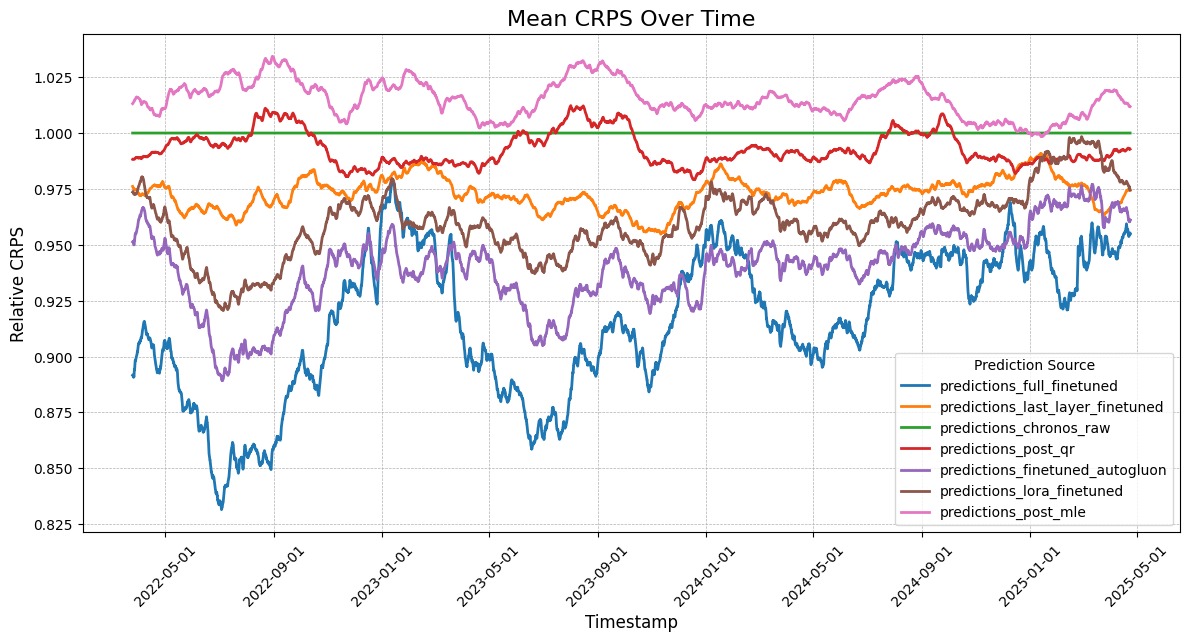

In [228]:
plot_crps({k: all_predictions[k] for k in selected_keys}, rolling_window=2000, reference_predictions="predictions_chronos_raw")

### Evaluation for individual model prediction (more details)

In [ ]:
predictions_raw.get_crps(lead_times=[1, 12, 24, 32, 48, 64], mean=True)

{'Mean CRPS Score': 3436.78}

In [ ]:
predictions_raw.get_quantile_scores(lead_times=[1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64,QS averaged over all lead times
quantile,,,,,,,
0.1,281.06,999.10,1165.42,1273.94,1318.51,1376.24,1069.05
0.2,417.00,1510.41,1755.92,1951.83,2026.06,2121.92,1630.52
0.3,504.72,1829.20,2120.95,2374.42,2467.57,2584.93,1980.30
0.4,554.18,2000.92,2321.34,2603.57,2694.53,2826.18,2166.79
0.5,570.34,2045.00,2375.78,2655.95,2735.84,2869.26,2208.70
0.6,555.01,1967.60,2285.49,2537.47,2605.72,2734.61,2114.32
0.7,507.44,1765.87,2041.51,2247.49,2301.64,2418.28,1880.37
0.8,420.07,1424.42,1629.40,1773.75,1808.86,1907.49,1494.00
0.9,282.92,902.00,1007.73,1076.28,1097.99,1162.08,921.50


In [ ]:
predictions_raw.get_empirical_coverage_rates(lead_times=[1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64,Empirical coverage rates averaged over all lead times
quantile,,,,,,,
0.1,0.04,0.12,0.11,0.11,0.11,0.11,0.10
0.2,0.14,0.22,0.21,0.20,0.21,0.20,0.20
0.3,0.26,0.31,0.31,0.29,0.30,0.29,0.29
0.4,0.39,0.40,0.41,0.38,0.39,0.38,0.39
0.5,0.52,0.49,0.49,0.47,0.49,0.47,0.49
0.6,0.65,0.58,0.59,0.56,0.58,0.57,0.59
0.7,0.77,0.67,0.68,0.65,0.68,0.67,0.69
0.8,0.88,0.78,0.78,0.76,0.78,0.78,0.79
0.9,0.96,0.89,0.90,0.88,0.90,0.90,0.90


<Figure size 800x800 with 0 Axes>

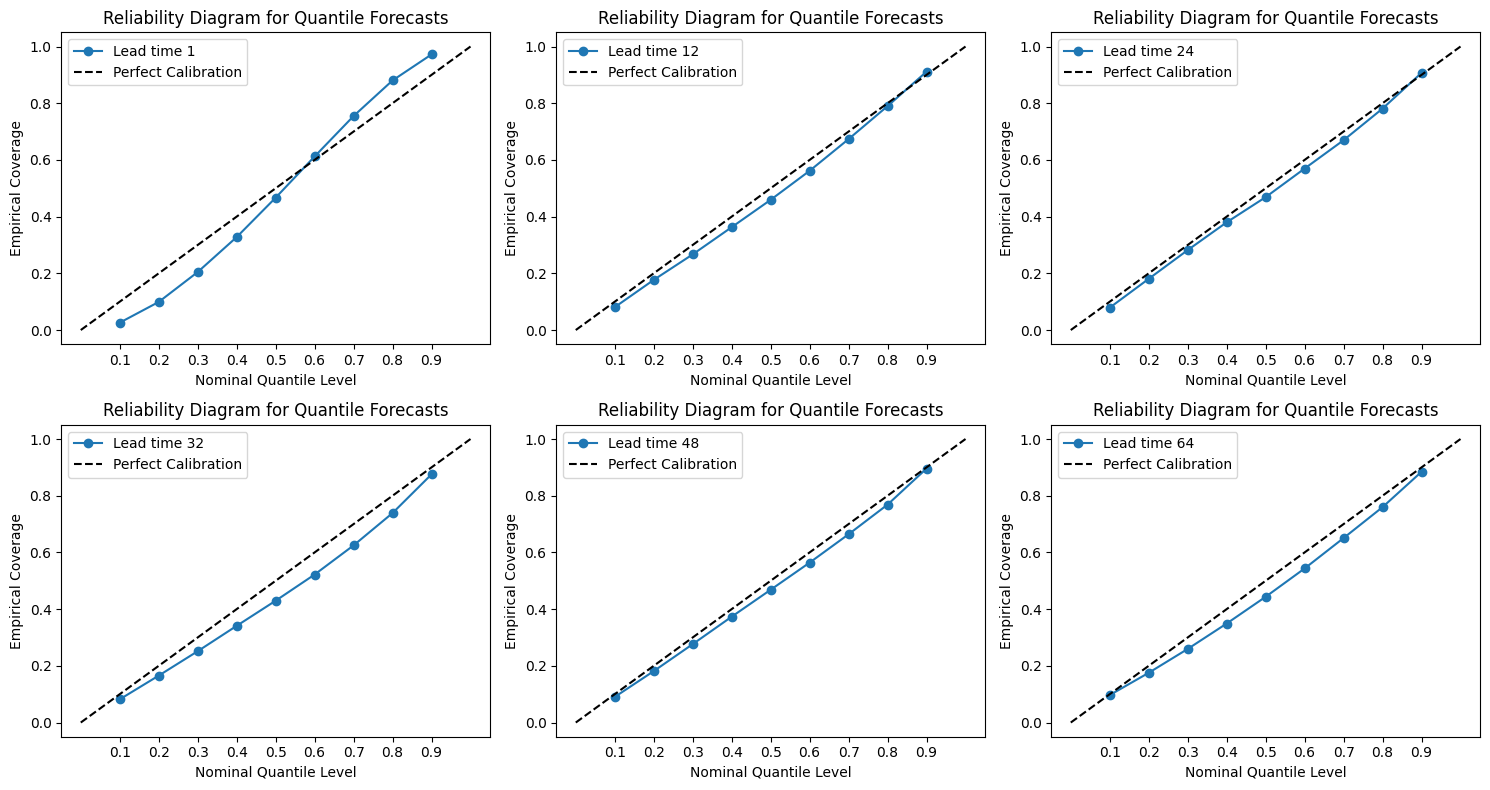

In [ ]:
predictions_raw.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64], item_ids=[0])

<Figure size 800x800 with 0 Axes>

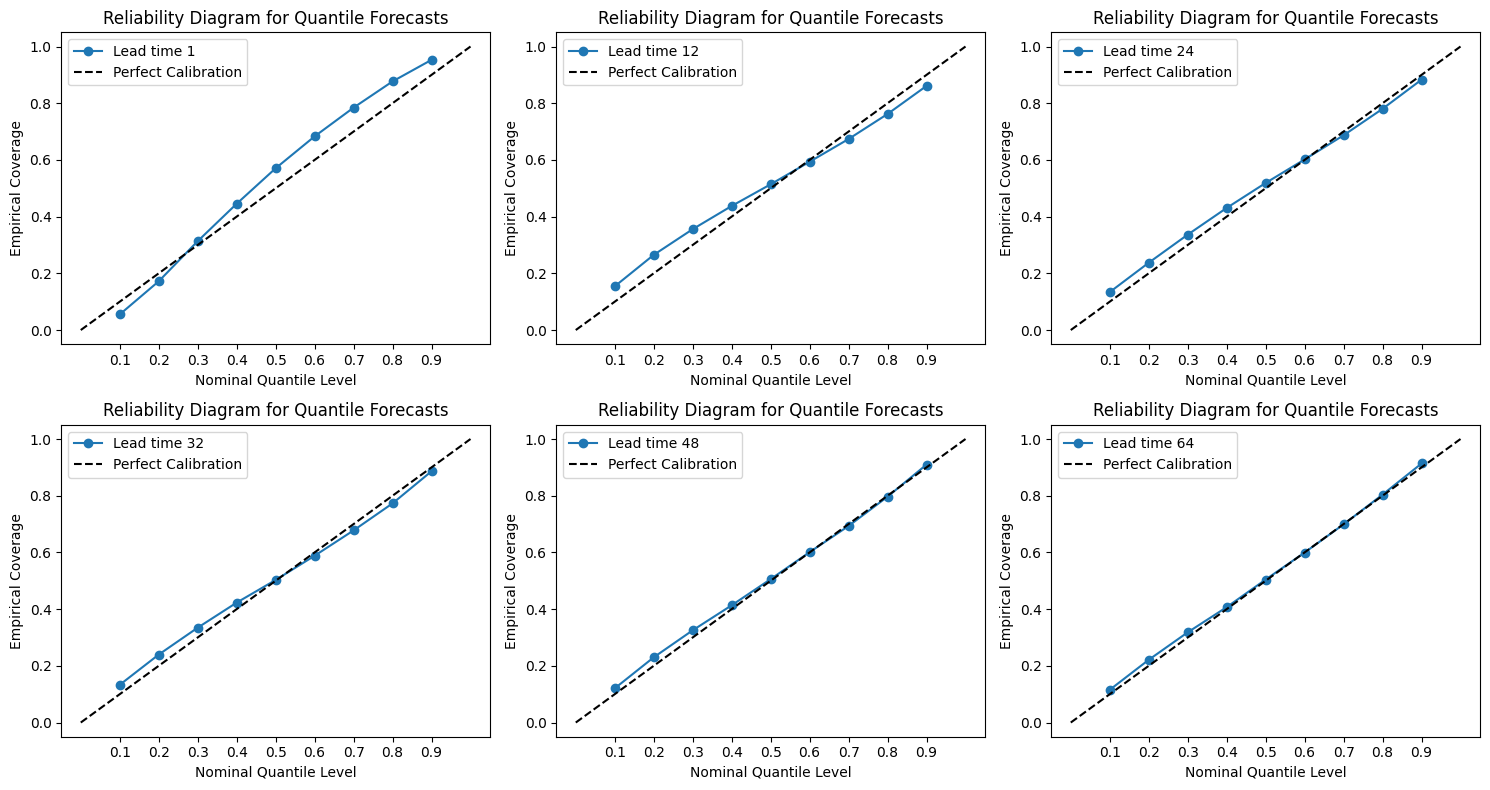

In [ ]:
predictions_raw.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64], item_ids=[1])

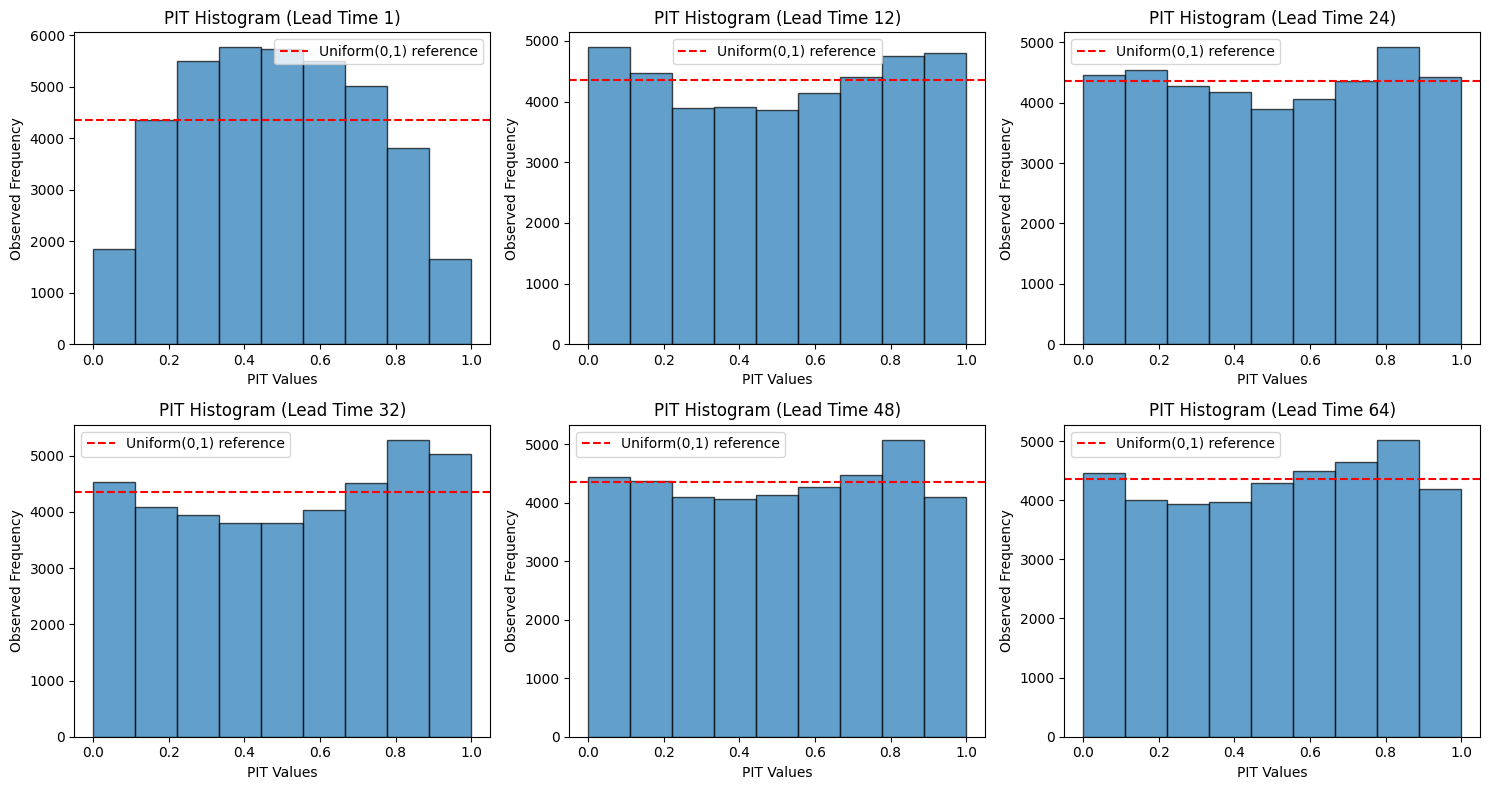

In [ ]:
predictions_raw.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

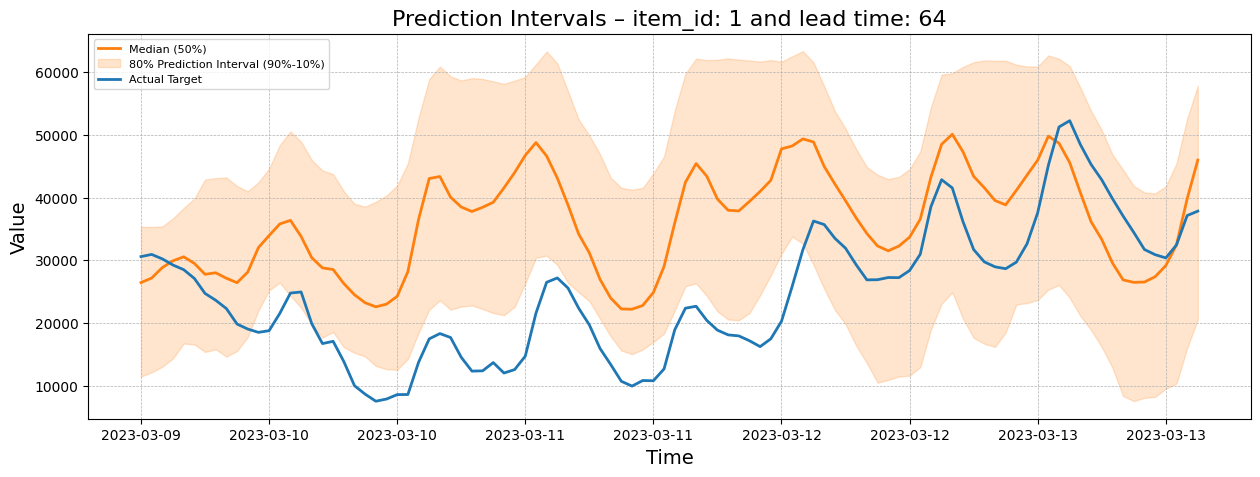

In [ ]:
predictions_benchmark_nn.results[64].get_random_plot(item_id=1)

# Additional Experiments

#### Compare chronos zero shot performance before and after 01-01-2023 against nn benchmark
- data used for training chronos goes until 2022. It might be that the gap between benchmark predictions and zero-shot chronos predictions increases after that.

In [ ]:
# create TimesSeriesDataFrame for convenience
data = TimeSeriesDataFrame(df)
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2020"))

lead_times = [1,4,8,12,24,36,48,60] # could also specify different ones
freq = pd.Timedelta("1h")

chronos = Chronos(model_name="amazon/chronos-bolt-tiny",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq,
                  )

# get zero shot perdictions on test dataset
predictions_raw = chronos.predict(data=data_test,
                                  previous_context_data=data_train)

nn_predictor = NNPredictor(quantiles = np.arange(0.1, 1, 0.1),
                           lead_times=lead_times,
                           freq=freq)

nn_predictor.fit(data_train)
predictions_benchmark_nn = nn_predictor.predict(data_test)

all_predictions = {"chronos_predictions_raw": predictions_raw, "predictions_benchmark_nn": predictions_benchmark_nn}

Load chronos pipeline.


100%|██████████| 93108/93108 [00:19<00:00, 4886.58it/s]


In [ ]:
get_crps_by_period(all_predictions, 
                   lead_times=None, 
                   item_ids=None, 
                   reference_predictions="predictions_benchmark_nn",
                   date_splits=[ pd.Timestamp("01-01-2023")])

,chronos_predictions_raw,predictions_benchmark_nn
2020-01-01 00:00:00_to_2023-01-01 00:00:00,0.632009,1.0
2023-01-01 00:00:00_to_2025-04-23 23:00:00,0.629481,1.0
